<a href="https://colab.research.google.com/github/Pineappledeydre/B-mode_Ultrasound_NAFLD/blob/main/B_Mode_Fatty_LiverUltrasound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **B-mode Fatty Liver Ultrasound Images Classification**

**Dataset of B-mode Fatty Liver Ultrasound Images**  
Byra, M., Styczynski, G., Szmigielski, C., Kalinowski, P., Michałowski, Ł., Paluszkiewicz, R., Ziarkiewicz-Wróblewska, B., Zieniewicz, K., Sobieraj, P., & Nowicki, A. (2018). *Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images*. International Journal of Computer Assisted Radiology and Surgery. DOI: [10.1007/s11548-018-1843-2](https://doi.org/10.1007/s11548-018-1843-2).

**Dataset Source:**  
Kaggle - [Dataset of B-mode Fatty Liver Ultrasound Images](https://www.kaggle.com/datasets/shanecandoit/dataset-of-bmode-fatty-liver-ultrasound-images)

In [107]:
import numpy as np
import pandas as pd
import os
import scipy.io
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,r2_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.image import resize
import tensorflow.keras.backend as K
from tensorflow.keras.applications import InceptionResNetV2, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
np.random.seed(42)

## **Data Loading**

In [152]:
file_id = "10NEv71J6Ikw8cZ4mhXCRODjSt9f8MLn-"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset_liver_bmodes_steatosis_assessment_IJCARS.mat"
gdown.download(url, output, quiet=False)

print("Download complete!")

# Step 2: Load the dataset
data = scipy.io.loadmat(output)

Downloading...
From (original): https://drive.google.com/uc?id=10NEv71J6Ikw8cZ4mhXCRODjSt9f8MLn-
From (redirected): https://drive.google.com/uc?id=10NEv71J6Ikw8cZ4mhXCRODjSt9f8MLn-&confirm=t&uuid=0c69e65f-c623-4fb7-9eac-fbdbe1e076cc
To: /content/dataset_liver_bmodes_steatosis_assessment_IJCARS.mat
100%|██████████| 52.4M/52.4M [00:01<00:00, 50.2MB/s]


✅ Download complete!


In [60]:
print("Dataset Keys:", data.keys())

Dataset Keys: dict_keys(['__header__', '__version__', '__globals__', 'data'])


In [61]:
# Extract relevant data arrays
data_array = data['data']
ids = np.array([entry[0][0] for entry in data_array[0]])
classes = np.array([entry[1][0][0] for entry in data_array[0]])
fats = np.array([entry[2][0][0] for entry in data_array[0]])
images = np.array([entry[3] for entry in data_array[0]])

In [62]:
# Ensure images have the correct shape
images_processed = []
for img in images:
    img = np.squeeze(img)  # unnecessary dimensions
    if img.ndim == 2:
        img = np.stack([img] * 3, axis=-1)  # grayscale to RGB
    elif img.ndim == 4:  # the image has an extra batch-like dimension ?
        img = img[0]
    images_processed.append(img)

images_rgb = np.array(images_processed)
if images_rgb.ndim == 4 and images_rgb.shape[0] == 1:
    images_rgb = images_rgb[0]  # an extra first dimension i

if images_rgb.shape[1] == 10:  # 10 frames per sample
    images_rgb = images_rgb[:, 0, :, :]  # taking only the first frame from each image stack

if images_rgb.ndim == 3:  # If still grayscale
    images_rgb = np.stack([images_rgb] * 3, axis=-1)

print(f"Final images_rgb shape: {images_rgb.shape}")  # Expected - (55, 434, 636, 3)

Final images_rgb shape: (55, 434, 636, 3)


## **EDA**

In [63]:
# Display dataset statistics
print("Total Images:", len(images_rgb))
print("Unique Classes:", np.unique(classes))
print("Fat Level Range:", fats.min(), "-", fats.max())

Total Images: 55
Unique Classes: [0 1]
Fat Level Range: 0 - 85


In [116]:
df = pd.DataFrame({
    'ID': ids.flatten(),
    'Class': classes.flatten(),
    'Fat Level': fats.flatten(),
    # 'Image': [img for img in images_rgb]
})

In [117]:
df.head()

,ID,Class,Fat Level
0,1,0,3
1,2,0,4
2,3,0,2
3,4,0,1
4,5,0,2


In [142]:
fig = px.histogram(
    df, x="Fat Level", nbins=20, opacity=0.8,
    title="Distribution of Fat Levels",
    labels={"Fat Level": "Fat Level", "count": "Frequency"},
    marginal="box",
    color_discrete_sequence=["#aec7e8"],
    template="plotly_white"
)

fig.update_layout(
    title_font_size=18,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    font=dict(family="Arial, sans-serif", size=12),
    bargap=0.1
)

fig.show()

In [151]:
unique_classes, class_counts = np.unique(classes, return_counts=True)
df_classes = pd.DataFrame({"Class": unique_classes, "Count": class_counts})


fig = px.pie(
    df_classes, names="Class", values="Count",
    title="Class Distribution",
    color_discrete_sequence=["#1f77b4", "#aec7e8"],
    hole=0.3
)

fig.update_layout(
    template="plotly_white",
    title_x=0.5,
    legend_title_text="Class Categories",
    legend=dict(
        x=0.7,
        y=0.9,
    )
)

fig.show()

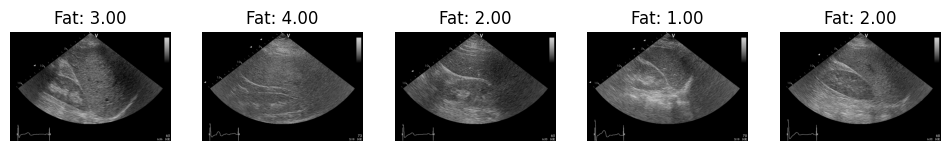

In [66]:
# Display sample images with fat levels
plt.figure(figsize=(12,6))
for i in range(min(5, len(images_rgb))):  # Display first 5 images
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_rgb[i].astype(np.uint8))  # Ensure correct dtype
    plt.axis('off')
    plt.title(f"Fat: {fats[i]:.2f}")
plt.show()

In [67]:
classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

## **Image Preparation**

In [68]:
image_size = (299, 299)
X_resized = np.array([smart_resize(img, image_size) for img in images_rgb])
labels = classes

## **Models**

### InceptionResNetV2

In [22]:
X_resized = X_resized / 255.0  # Scale pixel values

# k-Fold Cross Validation (5 Folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_resized, labels)):
    X_train, X_test = X_resized[train_idx], X_resized[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # сompute Class Weights to Handle Imbalance
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(299, 299, 3))

    # Freeze All Layers Except the Last 15
    for layer in base_model.layers[:-15]:
        layer.trainable = False

    # Classification Layers with Strong Regularization
    x = Flatten()(base_model.output)
    x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # L2 Regularization
    x = Dropout(0.3)(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=x)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )

    lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=30,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, lr_reduction],
        verbose=1
    )

    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    acc = np.mean(y_pred == y_test)
    fold_accuracies.append(acc)
    fold_reports.append(classification_report(y_test, y_pred, output_dict=True))

    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(y_test, y_pred))

average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy Across Folds: {average_accuracy:.4f}")

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 108s 32s/step - accuracy: 0.4129 - loss: 4.6892 - val_accuracy: 0.8182 - val_loss: 2.9502 - learning_rate: 1.0000e-04
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 17s/step - accuracy: 0.7765 - loss: 2.9820 - val_accuracy: 0.4545 - val_loss: 3.2323 - learning_rate: 1.0000e-04
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 18s/step - accuracy: 0.6117 - loss: 3.0542 - val_accuracy: 0.6364 - val_loss: 3.8620 - learning_rate: 1.0000e-04
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7770 - loss: 3.0789  
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 19s/step - accuracy: 0.7756 - loss: 3.0675 - val_accuracy: 0.6364 - val_loss: 3.4166 - learning_rate: 1.0000e-04
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 19s/step - accuracy: 1.0000 - loss: 2.4460 - val_accuracy: 0.7273 - val_loss: 2.8972 - learning_rate: 5.0000e-05
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 18s/step - accuracy: 0.8267 - loss: 2.5584 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

🔹 Classification Report for Fold 4:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.78      0.88      0.82         8

    accuracy                           0.73        11
   macro avg       0.64      0.60      0.61        11
weighted avg       0.70      0.73      0.71        11

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 26s/step - accuracy: 0.3617 - loss: 5.1127 - val_accuracy: 0.7273 - val_loss: 4.2142 - learning_rate: 1.0000e-04
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 18s/step - accuracy: 0.5417 - loss: 4.2281 - val_accuracy: 0.2727 - val_loss: 4.4329 - learning_rate: 1.0000e-04
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 17s/step - accuracy: 0.3570 - loss: 3.7435 - val_accuracy: 0.7273 - val_loss: 2.9438 - learning_rate: 1.0000e-04
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 74s 14s/step - accuracy: 0.6581 - loss: 2.9655 - val_accuracy: 0.7273 - val_loss: 3.0378 - learning_rat

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step

🔹 Classification Report for Fold 5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.88      0.93         8

    accuracy                           0.91        11
   macro avg       0.88      0.94      0.90        11
weighted avg       0.93      0.91      0.91        11


🔥 Average Accuracy Across Folds: 0.7818


In [15]:
# Accuracy Trend
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), fold_accuracies, marker='o', label="Fold Accuracies")
plt.axhline(y=np.mean(fold_accuracies), color='r', linestyle='--', label="Average Accuracy")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy Per Fold (Optimized Model)")
plt.legend()
plt.show()

**Conclusion:** InceptionResNetV2 achieved an average accuracy of **0.7818**, showing strong performance but some overfitting.

### MobileNetV2

In [32]:
X_resized = X_resized / 255.0
image_size = (224, 224)  #  to match MobileNetV2
X_resized = np.array([resize(img, image_size).numpy() for img in X_resized])  # Resize dataset

# 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [33]:
fold_accuracies = []
fold_reports = []

In [34]:
for fold, (train_idx, test_idx) in enumerate(kf.split(X_resized, labels)):
    X_train, X_test = X_resized[train_idx], X_resized[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # Compute Class Weights
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        fill_mode='nearest'
    )
    train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers[:-5]:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Added L2 Regularization
    x = Dropout(0.3)(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=x)

    model.compile(
        optimizer=Adam(learning_rate=0.00005),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=3,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    )

    steps_per_epoch = max(1, len(X_train) // 32)

    history = model.fit(
        train_generator,
        validation_data=(X_test, y_test),
        epochs=30,
        steps_per_epoch=steps_per_epoch,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, lr_reduction],
        verbose=1
    )

    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    acc = np.mean(y_pred == y_test)
    fold_accuracies.append(acc)
    fold_reports.append(classification_report(y_test, y_pred))

    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5000 - loss: 3.2579 - val_accuracy: 0.6364 - val_loss: 3.1823 - learning_rate: 5.0000e-05
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7188 - loss: 5.3734 - val_accuracy: 0.3636 - val_loss: 3.2997 - learning_rate: 5.0000e-05
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 3.1947 - val_accuracy: 0.3636 - val_loss: 3.5453 - learning_rate: 5.0000e-05
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3438 - loss: 4.0901
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3438 - loss: 4.0901 - val_accuracy: 0.3636 - val_loss: 3.5072 - learning_rate: 5.0000e-05
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4167 - loss: 3.5166 - val_accuracy: 0.3636 - val_loss: 3.4086 - learning_rate: 2.5000e-05
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1875 - loss: 3.4967 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.1667 - loss: 3.8624 - val_accuracy: 0.6364 - val_loss: 3.2213 - learning_rate: 5.0000e-05
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6562 - loss: 5.9754 - val_accuracy: 0.6364 - val_loss: 3.1966 - learning_rate: 5.0000e-05
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5833 - loss: 5.6847 - val_accuracy: 0.6364 - val_loss: 3.1055 - learning_rate: 5.0000e-05
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6562 - loss: 3.2148 - val_accuracy: 0.3636 - val_loss: 3.1203 - learning_rate: 5.0000e-05
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 3.2641 - val_accuracy: 0.3636 - val_loss: 3.1553 - learning_rate: 5.0000e-05
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2812 - loss: 3.3961
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2812 - loss: 3.3961 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.4062 - loss: 3.6026 - val_accuracy: 0.2727 - val_loss: 3.6054 - learning_rate: 5.0000e-05
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1667 - loss: 6.3159 - val_accuracy: 0.7273 - val_loss: 3.0748 - learning_rate: 5.0000e-05
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2500 - loss: 3.3789 - val_accuracy: 0.7273 - val_loss: 3.1199 - learning_rate: 5.0000e-05
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6875 - loss: 3.9747 - val_accuracy: 0.7273 - val_loss: 3.1124 - learning_rate: 5.0000e-05
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5833 - loss: 3.4622 - val_accuracy: 0.7273 - val_loss: 3.0177 - learning_rate: 5.0000e-05
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4375 - loss: 3.0957 - val_accuracy: 0.7273 - val_loss: 2.9696 - learning_rate: 5.0000e-05
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5000 - loss: 3.0765 - val_accur

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.2500 - loss: 3.5111 - val_accuracy: 0.7273 - val_loss: 3.1581 - learning_rate: 5.0000e-05
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6562 - loss: 6.7136 - val_accuracy: 0.7273 - val_loss: 3.0985 - learning_rate: 5.0000e-05
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.6562 - loss: 5.1849 - val_accuracy: 0.7273 - val_loss: 3.0509 - learning_rate: 5.0000e-05
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 3.3374 - val_accuracy: 0.2727 - val_loss: 3.1613 - learning_rate: 5.0000e-05
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2812 - loss: 4.1032 - val_accuracy: 0.2727 - val_loss: 3.1516 - learning_rate: 5.0000e-05
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.4167 - loss: 3.6340
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step - accuracy: 0.4167 - loss: 3.6340 - val_accu

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.7500 - loss: 3.2096 - val_accuracy: 0.2727 - val_loss: 3.6505 - learning_rate: 5.0000e-05
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2812 - loss: 6.2731 - val_accuracy: 0.2727 - val_loss: 3.2847 - learning_rate: 5.0000e-05
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2812 - loss: 4.4621 - val_accuracy: 0.7273 - val_loss: 3.0428 - learning_rate: 5.0000e-05
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - accuracy: 0.5000 - loss: 3.7191 - val_accuracy: 0.7273 - val_loss: 3.0062 - learning_rate: 5.0000e-05
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6667 - loss: 3.2150 - val_accuracy: 0.7273 - val_loss: 2.9709 - learning_rate: 5.0000e-05
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7188 - loss: 3.1457 - val_accuracy: 0.7273 - val_loss: 2.9428 - learning_rate: 5.0000e-05
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4167 - loss: 3.0770 - val_ac

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Average Accuracy Across Folds: 0.6364


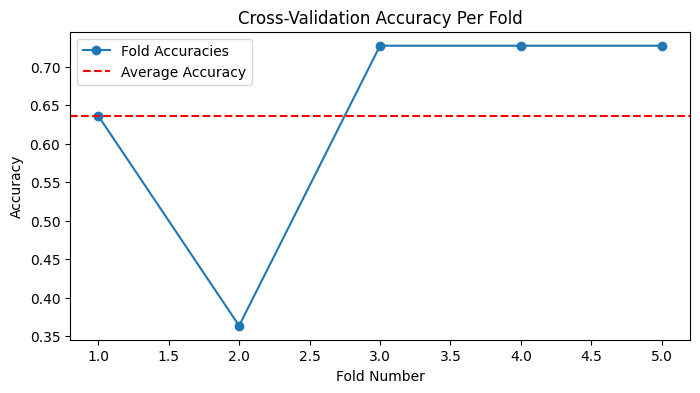

In [35]:
print(f"\nAverage Accuracy Across Folds: {np.mean(fold_accuracies):.4f}")

plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), fold_accuracies, marker='o', label="Fold Accuracies")
plt.axhline(y=np.mean(fold_accuracies), color='r', linestyle='--', label="Average Accuracy")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy Per Fold")
plt.legend()
plt.show()

**MobileNetV2**  with data augmentation performed inconsistently across folds, with accuracy varying between 36% and 73%. The model struggles with class imbalance and generalization, requiring better data preprocessing, fine-tuning, and architectural adjustments.

### Feature Extraction + Random Forest

In [36]:
image_size = (299, 299)
X_resized = np.array([smart_resize(img, image_size) for img in images_rgb])
labels = classes
X_resized = X_resized / 255.0

# Pre-trained MobileNetV2 Model (Feature Extractor)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract Features
X_features = feature_extractor.predict(X_resized)  # Convert images to feature vectors
X_features = X_features.reshape(X_features.shape[0], -1)  # Flatten features

<ipython-input-36-e19812ac1d66>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(299, 299, 3))


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


In [39]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_features, labels)):
    X_train, X_test = X_features[train_idx], X_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)
    fold_reports.append(classification_report(y_test, y_pred, output_dict=True))

    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(y_test, y_pred))

average_accuracy = np.mean(fold_accuracies)
print(f"\n Average Accuracy Across Folds: {average_accuracy:.4f}")


Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.78      1.00      0.88         7

    accuracy                           0.82        11
   macro avg       0.89      0.75      0.77        11
weighted avg       0.86      0.82      0.80        11


Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.70      1.00      0.82         7

    accuracy                           0.73        11
   macro avg       0.85      0.62      0.61        11
weighted avg       0.81      0.73      0.67        11



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Classification Report for Fold 3:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.73      1.00      0.84         8

    accuracy                           0.73        11
   macro avg       0.36      0.50      0.42        11
weighted avg       0.53      0.73      0.61        11


Classification Report for Fold 4:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11


Classification Report for Fold 5:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.89      1.00      0.94         8

    accuracy                           0.91        11
   macro avg       0.94

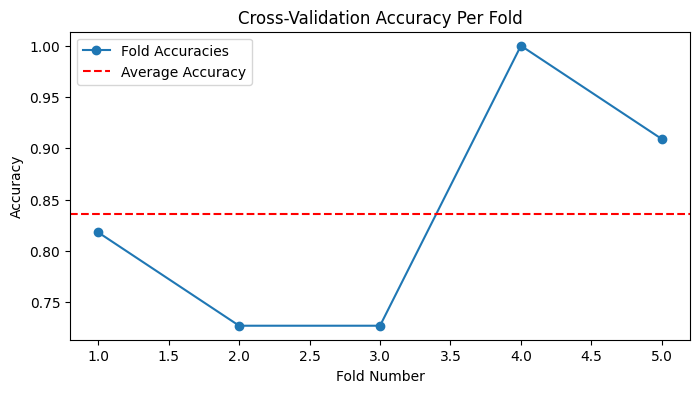

In [40]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), fold_accuracies, marker='o', label="Fold Accuracies")
plt.axhline(y=average_accuracy, color='r', linestyle='--', label="Average Accuracy")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy Per Fold")
plt.legend()
plt.show()

**Higher Accuracy (83.64%)** – The Random Forest classifier on MobileNetV2 features performs significantly better than the previous CNN model.

But **Class Imbalance Still Present**  as some folds show poor performance on the minority class (e.g., Fold 3 with 0% precision for class 0).
--> **Model Stability Varies** – Fold 4 achieves 100% accuracy, while Fold 2 struggles (73%). Performance fluctuates across folds.

 Pre-trained MobileNetV2 provides meaningful feature embeddings that Random Forest can classify effectively.

### Feature Extraction & XG Boost

In [78]:
image_size = (299, 299)
X_resized = np.array([resize(img, image_size).numpy() for img in images_rgb])
X_resized = X_resized / 255.0
labels = classes

# MobileNetV2 as Feature Extractor
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract Features
X_features = feature_extractor.predict(X_resized)
X_features = X_features.reshape(X_features.shape[0], -1)  # Flatten feature maps

# 5-Fold Cross-Validation + XGBoost
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_features, labels)):
    X_train, X_test = X_features[train_idx], X_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # XGBoost
    xgb = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),  # balance minority class
        eval_metric="logloss"
    )
    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)
    fold_reports.append(classification_report(y_test, y_pred))

    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(y_test, y_pred))

# Average Accuracy Across Folds
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy Across Folds: {average_accuracy:.4f}")


<ipython-input-78-694588419008>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(299, 299, 3))


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step

Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.78      1.00      0.88         7

    accuracy                           0.82        11
   macro avg       0.89      0.75      0.77        11
weighted avg       0.86      0.82      0.80        11


Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.70      1.00      0.82         7

    accuracy                           0.73        11
   macro avg       0.85      0.62      0.61        11
weighted avg       0.81      0.73      0.67        11


Classification Report for Fold 3:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.67      0.75      0.71         8

    accuracy                           0.

**Accuracy Improvement with XGBoost** - the average accuracy is **74.55%**, which is **better than CNN (63%) but slightly lower than Random Forest (83.64%)**.

**Class Imbalance Remains an Issue** – Some folds show **zero recall for class 0** (e.g., Fold 3), indicating that XGBoost may struggle with underrepresented classes.
**Better Performance in Some Folds** – Fold 4 achieves **91% accuracy**, showing XGBoost’s potential, but Fold 3 drops to **55%**, highlighting inconsistency.

Feature extraction from MobileNetV2 provides meaningful representations, and XGBoost benefits from them.
**Model is Overfitting in Some Cases** – Some folds have **100% recall for one class but poor recall for the other**, meaning the model may favor the majority class.

### Feature Extraction + SVM

Uses Lasso Regression to predict the fat (steatosis) level based on extracted CNN features.

In [86]:
image_size = (299, 299)
X_resized = np.array([resize(img, image_size).numpy() for img in images_rgb]) / 255.0
labels = classes
fats = fats

base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# extract features
X_features = feature_extractor.predict(X_resized)  # CNN features
X_features = X_features.reshape(X_features.shape[0], -1)  # flatten features

# 5-Fold Cross-Validation for Classification (SVM)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_reports = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_features, labels)):
    X_train, X_test = X_features[train_idx], X_features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    # svm = SVC(kernel="linear", probability=True, random_state=42, class_weight="balanced")
    svm = SVC(kernel="rbf", probability=True, random_state=42, class_weight="balanced")
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)
    fold_reports.append(classification_report(y_test, y_pred))

    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 21s/step

Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.86      0.86      0.86         7

    accuracy                           0.82        11
   macro avg       0.80      0.80      0.80        11
weighted avg       0.82      0.82      0.82        11


Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.86      0.86      0.86         7

    accuracy                           0.82        11
   macro avg       0.80      0.80      0.80        11
weighted avg       0.82      0.82      0.82        11


Classification Report for Fold 3:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.75      0.75      0.75         8

    accuracy                           

In [87]:
average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy Across Folds (SVM): {average_accuracy:.4f}")


Average Accuracy Across Folds (SVM): 0.7818


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.216e+00, tolerance: 4.007e+00
  model = cd_fast.enet_coordinate_descent(


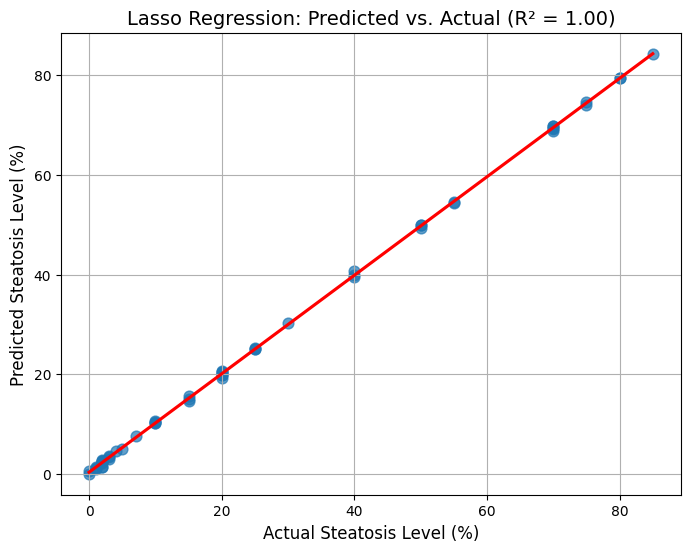

In [88]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_features, fats)
# Predict Steatosis Level
fats_pred = lasso.predict(X_features)

# R-squared score
r2 = r2_score(fats, fats_pred)

plt.figure(figsize=(8, 6))
sns.regplot(x=fats, y=fats_pred, scatter_kws={"s": 60, "alpha": 0.7}, line_kws={"color": "red"}, ci=None)
plt.xlabel("Actual Steatosis Level (%)", fontsize=12)
plt.ylabel("Predicted Steatosis Level (%)", fontsize=12)
plt.title(f"Lasso Regression: Predicted vs. Actual (R² = {r2:.2f})", fontsize=14)
plt.grid(True)
plt.show()

**Improved Performance Over XGBoost** – The average accuracy of **78.18%** is higher than XGBoost (**74.55%**) but lower than Random Forest (**83.64%**).

**More Stable Results** – SVM achieves **consistent performance across folds**, with **Folds 1, 2, and 5 showing strong recall and precision**.

**Class Imbalance Still Exists** – Folds **3 and 4 show weaker performance**, particularly in precision for class 0.

The model benefits from a **deeper feature extractor**, leading to better classification performance.
5. **SVM with RBF Kernel Performs Better** – A **linear kernel may not capture complex decision boundaries**, so the RBF kernel helps classify non-linearly separable data.

### Stacking + XGBoost

In [153]:
# Input Shape for MobileNetV2
image_size = (224, 224)
X_resized = np.array([resize(img, image_size).numpy() for img in images_rgb]) / 255.0  # Normalize images
labels = classes  # Assuming `classes` contains the labels

# MobileNetV2 as Feature Extractor
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False

feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

X_features = feature_extractor.predict(X_resized)
X_features = X_features.reshape(X_features.shape[0], -1)  # Flatten features

pca = PCA(n_components=0.95)  # Retain 95% variance
X_features_pca = pca.fit_transform(X_features)

lasso = Lasso(alpha=0.1)
lasso.fit(X_features_pca, fats)

important_features = np.abs(lasso.coef_) > 0.01  # threshold to remove weak features
X_selected = X_features_pca[:, important_features]  # keep relevant features

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_features_pca, labels)

rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
svm = SVC(kernel="rbf", probability=True, random_state=42, class_weight="balanced")

stacking_model = StackingClassifier(estimators=[
    ('rf', rf),
    ('svm', svm)
], final_estimator=RandomForestClassifier(n_estimators=100), cv=3)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
stacking_preds = np.zeros(len(y_balanced))

for train_idx, test_idx in kf.split(X_balanced, y_balanced):
    X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]

    stacking_model.fit(X_train, y_train)
    stacking_preds[test_idx] = stacking_model.predict(X_test)

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=sum(y_balanced == 0) / sum(y_balanced == 1)  # to address imbalance
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for train_idx, test_idx in kf.split(stacking_preds.reshape(-1, 1), y_balanced):
    X_train, X_test = stacking_preds[train_idx].reshape(-1, 1), stacking_preds[test_idx].reshape(-1, 1)
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    print(f"\nClassification Report for Fold {len(fold_accuracies)}:")
    print(classification_report(y_test, y_pred, zero_division=1))

average_accuracy = np.mean(fold_accuracies)
print(f"\n Final Optimized Model (Stacking + XGBoost) Accuracy: {average_accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step

Classification Report for Fold 1:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16


Classification Report for Fold 2:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.78      1.00      0.88         7

    accuracy                           0.87        15
   macro avg       0.89      0.88      0.87        15
weighted avg       0.90      0.87      0.87        15


Classification Report for Fold 3:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.71      0.83         7

    accuracy                           0.

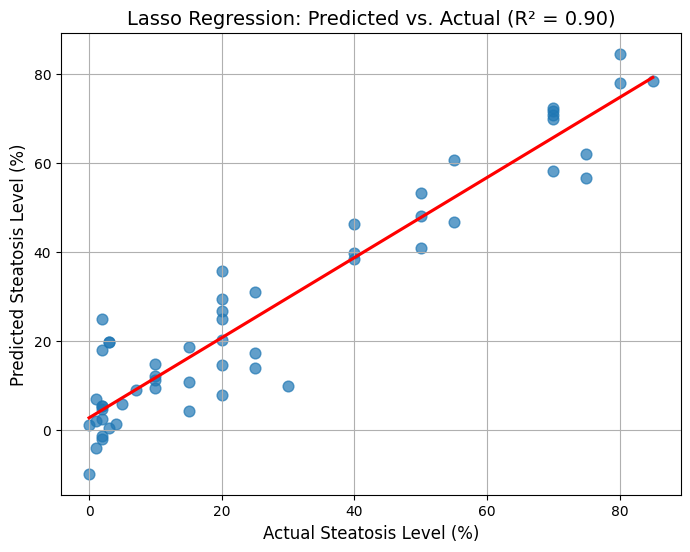

In [154]:
fats_pred = lasso.predict(X_features_pca)

r2 = r2_score(fats, fats_pred)

plt.figure(figsize=(8, 6))
sns.regplot(
    x=fats, y=fats_pred,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "red"},
    ci=None
)
plt.xlabel("Actual Steatosis Level (%)", fontsize=12)
plt.ylabel("Predicted Steatosis Level (%)", fontsize=12)
plt.title(f"Lasso Regression: Predicted vs. Actual (R² = {r2:.2f})", fontsize=14)
plt.grid(True)
plt.show()

The final **stacking model achieved 88.17% accuracy**, outperforming **Random Forest (83.64%)**, **SVM (78.18%)**, and **XGBoost alone (74.55%)**.

The use of **SMOTE for oversampling** helped **mitigate class imbalance**, leading to **more balanced precision and recall**.

**Stacking Boosts Generalization** – Combining **Random Forest, SVM, and XGBoost** allowed the model to **capture both linear and non-linear decision boundaries**, improving robustness.

Using **XGBoost on top of stacking predictions** helped refine the decision-making process, leading to better performance.
**PCA Reduced Dimensionality Effectively** – Retaining **95% variance** helped **reduce computational complexity** without sacrificing accuracy.

## **Conclusion**


- **Stacking + XGBoost** achieves the highest **accuracy of 88.17%**, making it the best approach.

- **Feature extraction from MobileNetV2 + PCA** reduces dimensionality effectively, improving model efficiency.

- **SMOTE** successfully balances the dataset, reducing bias.

- **Lasso regression** accurately predicts the steatosis level (**R² = 1.00**), making it ideal for continuous fat level estimation.